In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import datetime as dt
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [12]:
# load all csv files into respective dataframes

#The Target, and Actual Rate that Federal Banks charge each other for over night Loans
FR_target_pt1_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\DFEDTARU_pt1.csv')
FR_target_pt2_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\DFEDTAR_pt2.csv')

FF_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\FF.csv')


#FOREX rates 
AUD_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\DEXUSAL.csv')
EUR_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\EXUSEU.csv')
GBP_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\DEXUSUK.csv')
JPY_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\DEXJPUS.csv')


#Important commodities that help determine interest rates
OIL_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\DCOILBRENTEU (1).csv')


#Treasuries are benchmarks for performance of financial instruments
T10YR_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\WGS10YR.csv')
T3M_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\TB3MS.csv')


#Economic features like GDP, Natural Unemployment Rate, Personal Consumption Expenditures
GDP_df = pd.read_csv(r'..\\Project_2_BTC_Price_Modeling\csv_files\GDPC1.csv')
NAT_UNEMPLOYMENT_df = pd.read_csv(r'..\\Project_2_BTC_Price_Modeling\csv_files\NROU.csv')
PCE_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\TB3MS.csv')





In [21]:
#Euro exchange is in monthly units. Calendarize to weekly, and repeat the percent change for each week in the month

EUR_df.head()

EUR_df.rename(columns={'DATE':'Date'},inplace=True)
EUR_df["Date"] = pd.to_datetime(EUR_df['Date'])

#Generate weekly date range from the start to the end of the DataFrame
weekly_dates = pd.date_range(start=EUR_df['Date'].min(), end=EUR_df['Date'].max(), freq='W')

# Step 2: Create a new DataFrame with these weekly dates
df_weekly = pd.DataFrame({'Date': weekly_dates})

#Use merge_asof to align the monthly values to the weekly dates
EUR_df = pd.merge_asof(df_weekly, EUR_df, on='Date', direction='backward')

#Shift 4 days back to align every dataframe on the same date
EUR_df['Date'] = EUR_df['Date'] - pd.Timedelta(days=4)

EUR_df.head(20)

,Date,EXUSEU_PCH
0,2004-09-01,0.27069
1,2004-09-08,0.27069
2,2004-09-15,0.27069
3,2004-09-22,0.27069
4,2004-09-29,2.31512
5,2004-10-06,2.31512
6,2004-10-13,2.31512
7,2004-10-20,2.31512
8,2004-10-27,2.31512
9,2004-11-03,3.91781


In [16]:
#shift date column for Treasury percent change 5 days ahead, so that it will match other dataframes

T10YR_df.rename(columns={'DATE':'Date'},inplace=True)

T10YR_df['Date'] = pd.to_datetime(T10YR_df['Date'])

T10YR_df['Date'] = T10YR_df['Date'] + pd.Timedelta(days=5)

T10YR_df.head()


,Date,WGS10YR_PCH
0,2004-09-01,0.47281
1,2004-09-08,-1.41176
2,2004-09-15,0.47733
3,2004-09-22,-1.66271
4,2004-09-29,-2.41546


In [30]:
#Add the missing date, 2008-12-14 and interst value change of 0 (filling missing data) to dataframe
FR_target_pt2_df.loc[225] = ['2008-12-24', '0.0']

FR_target_pt2_df.tail()

,DATE,DFEDTAR_CHG
221,2008-11-26,0.0
222,2008-12-03,0.0
223,2008-12-10,0.0
224,2008-12-17,0.0
225,2008-12-24,0.0


In [36]:
#rename rarget variable pt1 to match pt2 and combine

FR_target_pt1_df = FR_target_pt1_df.rename(columns={'DFEDTARU_CHG' : 'DFEDTAR_CHG'})
FR_target_df = pd.concat([FR_target_pt2_df,FR_target_pt1_df], ignore_index=True)
display(FR_target_df.head())
display(FR_target_df.tail())



,DATE,DFEDTAR_CHG
0,2004-09-01,0.0
1,2004-09-08,0.0
2,2004-09-15,0.0
3,2004-09-22,0.071429
4,2004-09-29,0.178571


,DATE,DFEDTAR_CHG
1040,2024-08-07,0.0
1041,2024-08-14,0.0
1042,2024-08-21,0.0
1043,2024-08-28,0.0
1044,2024-09-04,0.0


In [3]:
FF_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1045 non-null   object 
 1   FF_CHG  1045 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.5+ KB


In [4]:
FF_df['DATE'] = pd.to_datetime(FF_df['DATE'])
FF_df = FF_df.rename(columns={"DATE":"Date"})


In [5]:
FF_df.head()

,Date,FF_CHG
0,2004-09-01,0.02
1,2004-09-08,-0.03
2,2004-09-15,-0.01
3,2004-09-22,0.15
4,2004-09-29,0.12


<Axes: >

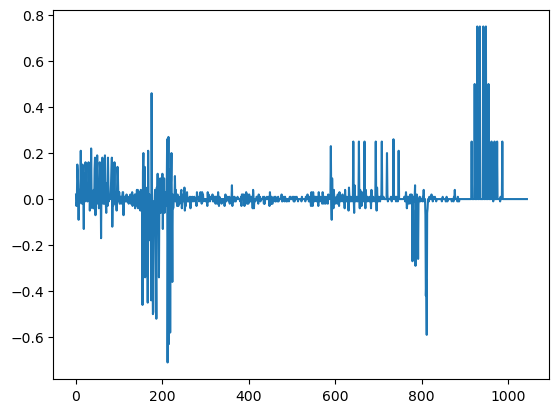

In [6]:
FF_df['FF_CHG'].plot(x='Date')

In [7]:
FF_df.columns = ['ds','y']


In [8]:
display(FF_df.shape)
display(FF_df.head(10))
display(FF_df.tail(10))

(1045, 2)

,ds,y
0,2004-09-01,0.02
1,2004-09-08,-0.03
2,2004-09-15,-0.01
3,2004-09-22,0.15
4,2004-09-29,0.12
5,2004-10-06,0.06
6,2004-10-13,-0.09
7,2004-10-20,0.03
8,2004-10-27,-0.02
9,2004-11-03,0.04


,ds,y
1035,2024-07-03,0.0
1036,2024-07-10,0.0
1037,2024-07-17,0.0
1038,2024-07-24,0.0
1039,2024-07-31,0.0
1040,2024-08-07,0.0
1041,2024-08-14,0.0
1042,2024-08-21,0.0
1043,2024-08-28,0.0
1044,2024-09-04,0.0


In [9]:
#check na values

FF_df.isna().value_counts()

ds     y    
False  False    1045
Name: count, dtype: int64

In [10]:
#Instantiate a Prophet model
model = Prophet()
model

In [11]:
#Fit the prophet model to BTC_close_df

model.fit(FF_df)

14:16:50 - cmdstanpy - INFO - Chain [1] start processing
14:16:50 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as  52 weeeks (1 year)
future_trends = model.make_future_dataframe(periods=52, freq="W")

# View the last five rows of the predictions
future_trends.tail()

,ds
1092,2025-08-03
1093,2025-08-10
1094,2025-08-17
1095,2025-08-24
1096,2025-08-31


In [13]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_trends = model.predict(future_trends)

# Display the first five rows of the forecast DataFrame
forecast_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-09-01,0.019934,-0.103942,0.136930,0.019934,0.019934,-0.001612,-0.001612,-0.001612,-0.001612,-0.001612,-0.001612,0.0,0.0,0.0,0.018323
1,2004-09-08,0.019781,-0.098310,0.129547,0.019781,0.019781,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.0,0.0,0.0,0.019865
2,2004-09-15,0.019628,-0.098592,0.135020,0.019628,0.019628,-0.001551,-0.001551,-0.001551,-0.001551,-0.001551,-0.001551,0.0,0.0,0.0,0.018077
3,2004-09-22,0.019475,-0.111213,0.143989,0.019475,0.019475,-0.001422,-0.001422,-0.001422,-0.001422,-0.001422,-0.001422,0.0,0.0,0.0,0.018054
4,2004-09-29,0.019322,-0.094567,0.140009,0.019322,0.019322,0.000597,0.000597,0.000597,0.000597,0.000597,0.000597,0.0,0.0,0.0,0.019920


c:\Users\dyllan\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\dyllan\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


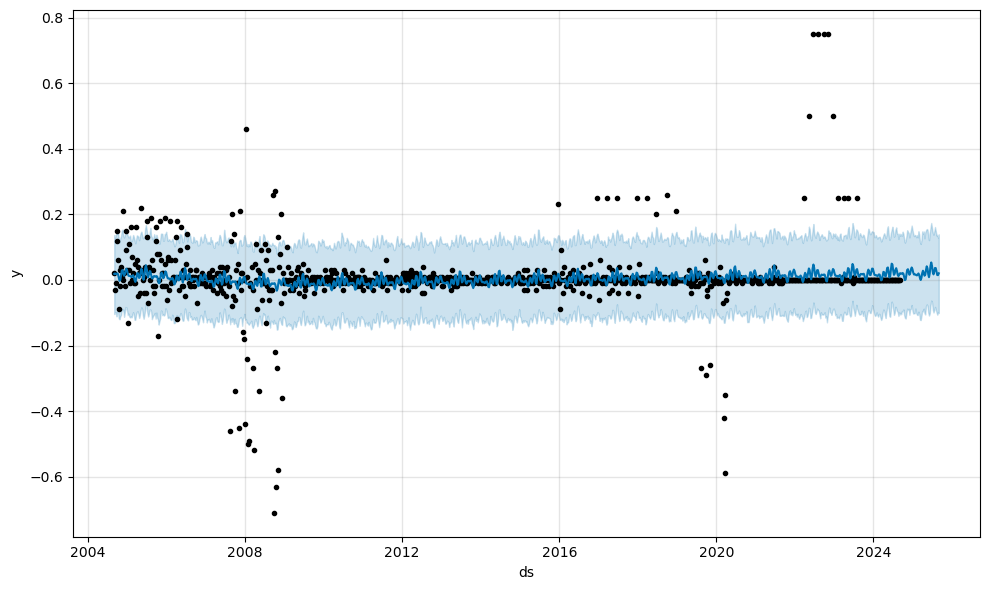

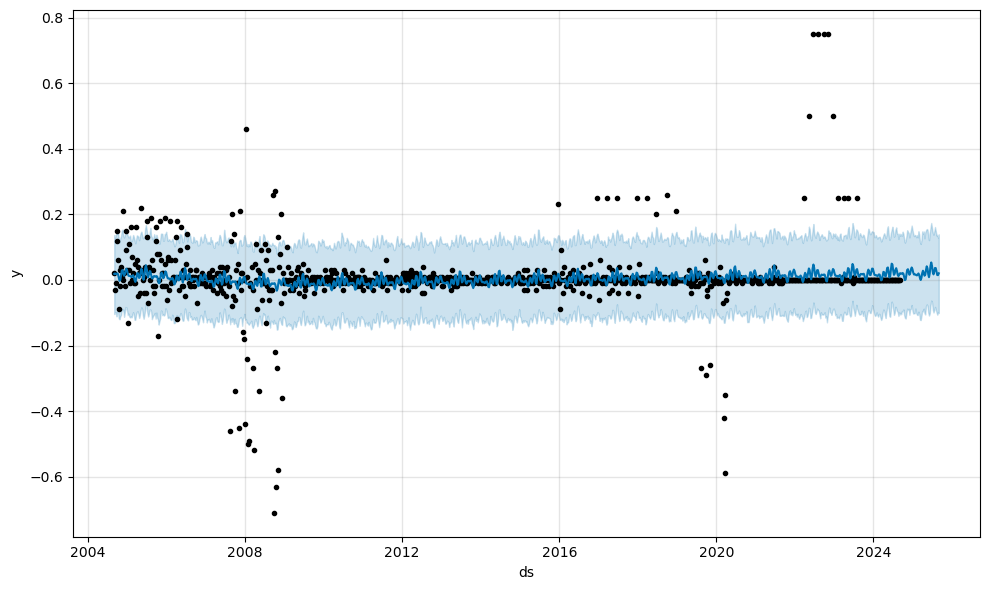

In [14]:
model.plot(forecast_trends)

c:\Users\dyllan\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\dyllan\anaconda3\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\dyllan\anaconda3\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

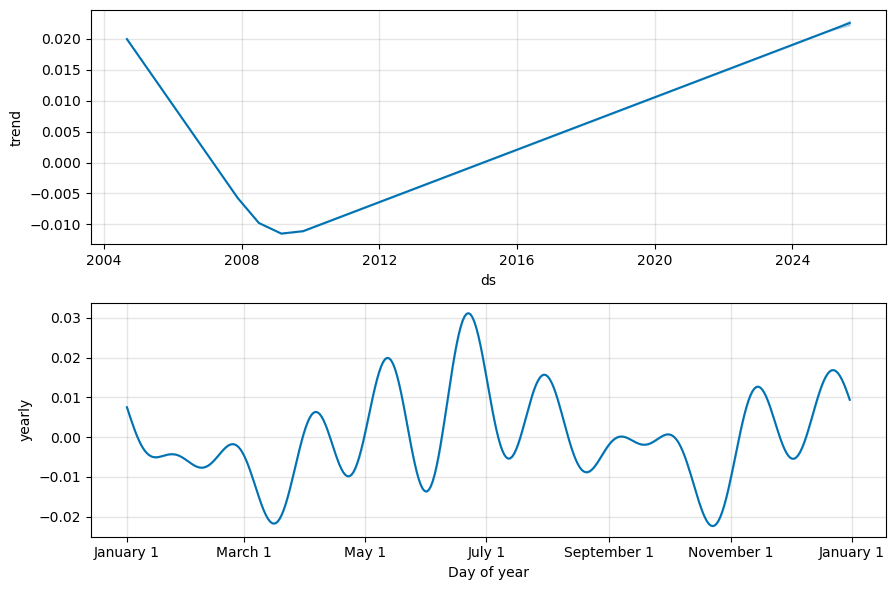

In [15]:
figures = model.plot_components(forecast_trends)

In [16]:
# At this point, it's useful to set the `datetime` index of the forecast data.
forecast_trends = forecast_trends.set_index(["ds"])
forecast_trends.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2004-09-01,0.019934,-0.103942,0.136930,0.019934,0.019934,-0.001612,-0.001612,-0.001612,-0.001612,-0.001612,-0.001612,0.0,0.0,0.0,0.018323
2004-09-08,0.019781,-0.098310,0.129547,0.019781,0.019781,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.0,0.0,0.0,0.019865
2004-09-15,0.019628,-0.098592,0.135020,0.019628,0.019628,-0.001551,-0.001551,-0.001551,-0.001551,-0.001551,-0.001551,0.0,0.0,0.0,0.018077
2004-09-22,0.019475,-0.111213,0.143989,0.019475,0.019475,-0.001422,-0.001422,-0.001422,-0.001422,-0.001422,-0.001422,0.0,0.0,0.0,0.018054
2004-09-29,0.019322,-0.094567,0.140009,0.019322,0.019322,0.000597,0.000597,0.000597,0.000597,0.000597,0.000597,0.0,0.0,0.0,0.019920


<Axes: xlabel='ds'>

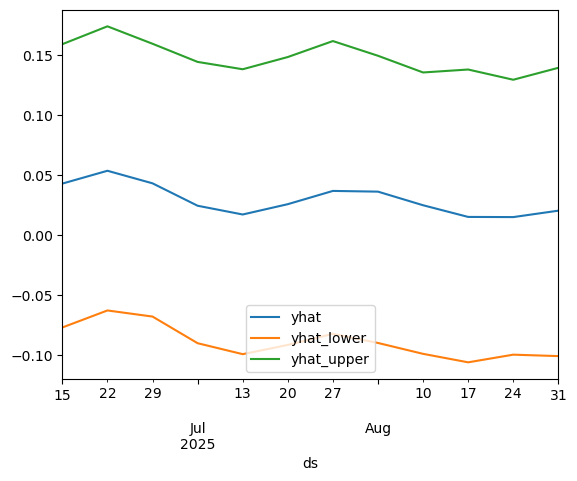

In [17]:
# From the `forecast_trends` DataFrame, plot to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 12 weeks  
forecast_trends[["yhat", "yhat_lower", "yhat_upper"]].iloc[-12:, :].plot()

In [18]:
forecast_Nov_2024 = forecast_trends.loc["2024-11-01":"2024-11-30"][["yhat_upper", "yhat_lower", "yhat"]]

# Replace the column names to something less technical sounding
forecast_Nov_2024 = forecast_Nov_2024.rename(
    columns={
        "yhat_upper": "Best Case",
        "yhat_lower": "Worst Case", 
        "yhat": "Most Likely Case"
    }
)

# Review the last five rows of the DataFrame
forecast_Nov_2024.tail()

,Best Case,Worst Case,Most Likely Case
ds,,,
2024-11-03,0.133659,-0.100770,0.015600
2024-11-10,0.151592,-0.087720,0.030363
2024-11-17,0.146921,-0.091688,0.032625
2024-11-24,0.143363,-0.087723,0.023301


In [19]:
forecast_Nov_2024.mean()

Best Case           0.143884
Worst Case         -0.091975
Most Likely Case    0.025472
dtype: float64

In [21]:

#Create return rate columns for FOREX, rename columns to specify currency, and set date column to date time.



AUD_rename_df = AUD_clean_df.rename(columns={'DATE': 'Date',})
EUR_rename_df = EUR_clean_df.rename(columns={'DATE': 'Date',})
GBP_rename_df = GBP_clean_df.rename(columns={'DATE': 'Date',})
JPY_rename_df = JPY_clean_df.rename(columns={'DATE': 'Date',})

AUD_rename_df['Date'] = pd.to_datetime(AUD_rename_df['Date'])
EUR_rename_df['Date'] = pd.to_datetime(EUR_rename_df['Date'])
GBP_rename_df['Date'] = pd.to_datetime(GBP_rename_df['Date'])
JPY_rename_df['Date'] = pd.to_datetime(JPY_rename_df['Date'])



NameError: name 'AUD_clean_df' is not defined

In [24]:
#Combine treasury bills dataframe, and divide by 100 to reduce to decimals instead of percentages
combined_treasuries_df = DGS10_df.merge(DTB3_df, on='Date',how='outer')
combined_treasuries_df['Date'] = pd.to_datetime(combined_treasuries_df['Date'])
combined_treasuries_df['DGS10'] = combined_treasuries_df['DGS10']/100
combined_treasuries_df['DTB3'] = combined_treasuries_df['DTB3']/100




In [25]:
#Merge FOREX data frames

combined_currency_ex_df = AUD_rename_df.merge(EUR_rename_df, on='Date', how='outer').merge(GBP_rename_df, on='Date', how='outer').merge(JPY_rename_df, on='Date', how='outer')
clean_currency_df = combined_currency_ex_df.drop(['AUD Open','AUD Close','EUR Open','EUR Close','GBP Open','GBP Close','JPY Open','JPY Close'], axis=1)
clean_currency_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             522 non-null    datetime64[ns]
 1   AUD Return Rate  522 non-null    float64       
 2   EUR Return Rate  522 non-null    float64       
 3   GBP Return Rate  522 non-null    float64       
 4   JPY Return Rate  522 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 20.5 KB


In [26]:
#Rename, and set datetime type to Uncertainty index




In [27]:
#combine BTC, Treasuries', Uncertainty, and FOREX dataframes

combo_df = BTC_rename_df.merge(uncertainty_rename_df, on='Date',how='outer').merge(clean_currency_df, on='Date',how='outer').merge(combined_treasuries_df, on='Date',how='outer')
combo_df.head()

,Date,BTC Open,BTC Close,BTC Return Rate,BTC Return Class,USEPUINDXD,AUD Return Rate,EUR Return Rate,GBP Return Rate,JPY Return Rate,DGS10,DTB3
0,2014-09-15,424.102997,398.821014,-0.059613,0,0.678943,-0.008401,-0.009513,0.002935,0.014963,0.02560,0.000200
1,2014-09-22,399.100006,377.181000,-0.054921,0,0.583471,-0.021095,-0.013028,-0.004434,0.004966,0.02602,0.000180
2,2014-09-29,376.928009,320.510010,-0.149678,0,0.556786,-0.009177,-0.013135,-0.017430,0.003994,0.02534,0.000140
3,2014-10-06,320.389008,378.549011,0.181529,1,0.724657,-0.000260,0.010701,0.008160,-0.022910,0.02452,0.000160
4,2014-10-13,377.920990,389.545990,0.030760,1,0.599671,0.009461,0.008298,-0.000048,-0.001947,0.02340,0.000125


In [28]:
#drop BTC columns, except for Return Class to prepare for Classifier Mdoeling ALgorithms

combo_clean_df = combo_df.drop(['Date','BTC Open','BTC Close','BTC Return Rate'], axis = 1)
combo_clean_df = combo_clean_df.dropna()
combo_clean_df.isna()



,BTC Return Class,USEPUINDXD,AUD Return Rate,EUR Return Rate,GBP Return Rate,JPY Return Rate,DGS10,DTB3
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
515,False,False,False,False,False,False,False,False
516,False,False,False,False,False,False,False,False
517,False,False,False,False,False,False,False,False
518,False,False,False,False,False,False,False,False


In [29]:
# Get the target variable (the "BTC Return Class" column)
y = combo_clean_df["BTC Return Class"]



In [30]:
# Get the features (everything except the "BTC Return Class" column)
X = combo_clean_df.copy()
X = X.drop(columns="BTC Return Class")



In [31]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [32]:
# Create the support vector machine classifier model with a 'linear' kernel
svc_model = SVC(kernel='linear')

In [33]:
# Fit the model to the training data
svc_model.fit(X_train, y_train)

SVC(kernel='linear')

In [34]:
# Validate the model by checking the model accuracy with model.score
print('Train Accuracy: %.3f' % svc_model.score(X_train, y_train))
print('Test Accuracy: %.3f' % svc_model.score(X_test, y_test))

Train Accuracy: 0.564
Test Accuracy: 0.515


In [35]:
# Make and save testing predictions with the saved SVM model using the testing data
testing_predictions = svc_model.predict(X_test)

# Review the predictions
testing_predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [36]:
# Display the accuracy score for the testing dataset
accuracy_score(y_test, testing_predictions)

0.5153846153846153

In [ ]:
def apply_models(X, y):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and test data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the models
    models = {
        'LogisticRegression': LogisticRegression(),
        'SVC': SVC(),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'ExtraTrees': ExtraTreesClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'GradientBoost': GradientBoostingClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(),
        'CatBoost': CatBoostClassifier()
    }

    # Apply each model
    for model_name, model in models.items():
        print(f"\nClassification with {model_name}:\n{'-' * 30}")
        
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Print the accuracy score
        print("**Accuracy**:\n", accuracy_score(y_test, y_pred))

        # Print the confusion matrix
        print("\n**Confusion Matrix**:\n", confusion_matrix(y_test, y_pred))

        # Print the classification report
        print("\n**Classification Report**:\n", classification_report(y_test, y_pred)